# Wang et al 2024 - Valence on healthy population

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency

## Importing and setting up the data

In [2]:

real_data = pd.read_csv("SRET2019.csv")
synthetic_data = pd.read_csv("synthetic_ddm_wang2024.csv")

# Combine 'Valence' and 'Circumplex' into a 'condition' column
real_data["condition"] = real_data["Valence"].str.lower() + "_" + real_data["Circumplex"].str.strip().str.lower().str.replace(" ", "_")

# Convert RT to seconds
real_data["rt"] = real_data["SERT.RT"] / 1000.0

# Convert yes/no to binary choice
real_data["choice"] = real_data["Response"].map({"yes": 1, "no": 0})

# Filter to just matching conditions in synthetic data
matched_conditions = synthetic_data["condition"].unique()
real_data_filtered = real_data[real_data["condition"].isin(matched_conditions)]

real_choice_rates = real_data_filtered.groupby("condition")["choice"].mean().reset_index(name="endorsement_rate")
real_choice_rates["source"] = "real"

synthetic_choice_rates = synthetic_data.groupby("condition")["choice"].mean().reset_index(name="endorsement_rate")
synthetic_choice_rates["source"] = "synthetic"

combined_choices = pd.concat([real_choice_rates, synthetic_choice_rates])


## Visualising the outputs of the synthetic vs real data

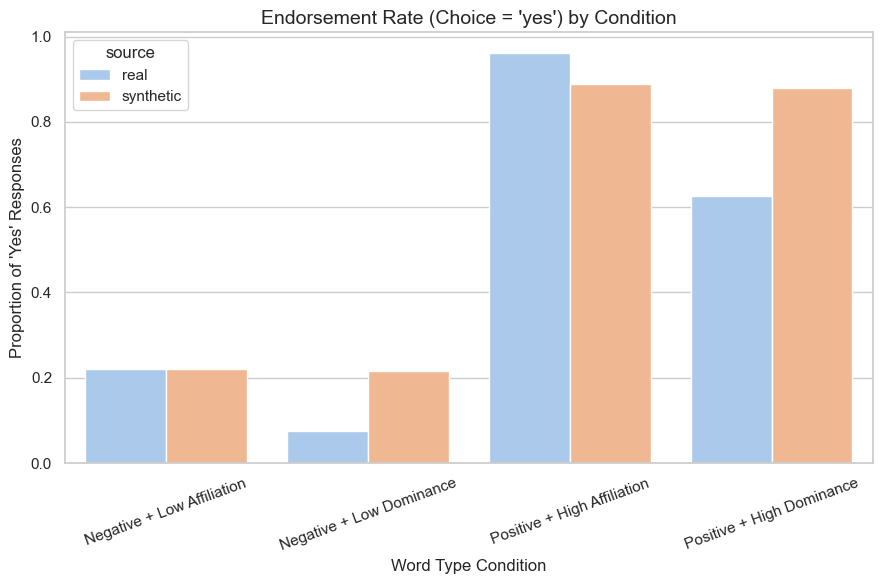

In [3]:

# Use pastel style and set context
sns.set(style="whitegrid", palette="pastel", context="notebook")

label_map = {
    "positive_high_dominance": "Positive + High Dominance",
    "positive_high_affiliation": "Positive + High Affiliation",
    "negative_low_dominance": "Negative + Low Dominance",
    "negative_low_affiliation": "Negative + Low Affiliation"
}

plot_data = combined_choices.copy()
plot_data["condition_label"] = plot_data["condition"].map(label_map)

# Custom pastel color palette (edit colors if desired)
pastel_palette = sns.color_palette("pastel")

# Unique sources (e.g., "clinical", "control", etc.)
sources = plot_data["source"].unique()
palette_map = {source: pastel_palette[i % len(pastel_palette)] for i, source in enumerate(sources)}

# Plot
plt.figure(figsize=(9, 6))
sns.barplot(
    data=plot_data,
    x="condition_label",
    y="endorsement_rate",
    hue="source",
    palette=palette_map
)
plt.title("Endorsement Rate (Choice = 'yes') by Condition", fontsize=14)
plt.ylabel("Proportion of 'Yes' Responses", fontsize=12)
plt.xlabel("Word Type Condition", fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## Statistically checking whether the two are different

In [6]:
results = []

for cond in plot_data["condition"].unique():
    real = real_data_filtered[real_data_filtered["condition"] == cond]["choice"]
    synth = synthetic_data[synthetic_data["condition"] == cond]["choice"]

    # Count choices: [yes, no]
    real_counts = [sum(real == 1), sum(real == 0)]
    synth_counts = [sum(synth == 1), sum(synth == 0)]

    # Combine into contingency table
    contingency = [real_counts, synth_counts]
    chi2, p, dof, expected = chi2_contingency(contingency)

    results.append({
        "condition": cond,
        "real_yes": real_counts[0],
        "real_no": real_counts[1],
        "synth_yes": synth_counts[0],
        "synth_no": synth_counts[1],
        "chi2": chi2,
        "p_value": p
    })

# Convert to DataFrame for viewing
df_stats = pd.DataFrame(results)
df_stats["condition_label"] = df_stats["condition"].map(label_map)
df_stats

,condition,real_yes,real_no,synth_yes,synth_no,chi2,p_value,condition_label
0,negative_low_affiliation,150,527,151,533,0.000000,1.000000e+00,Negative + Low Affiliation
1,negative_low_dominance,51,627,147,537,52.360375,4.619515e-13,Negative + Low Dominance
2,positive_high_affiliation,655,26,608,76,25.208120,5.146505e-07,Positive + High Affiliation
3,positive_high_dominance,424,253,602,82,116.770830,3.222304e-27,Positive + High Dominance


## Outputting into a nice table to C+P

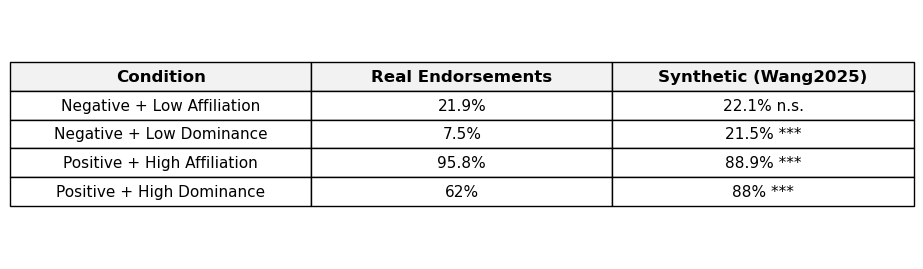

In [7]:
stats_data_output = {
    "Condition": [
        "Negative + Low Affiliation",
        "Negative + Low Dominance",
        "Positive + High Affiliation",
        "Positive + High Dominance"
    ],
    "Real Yes": ["21.9%", "7.5%", "95.8%", "62%"],
    "Real No": [527, 627, 26, 253],
    "Synthetic Yes": ["22.1%", "21.5%", "88.9%", "88%"],
    "Synthetic No": [533, 537, 76, 82],
    "Chi-Square": [0.00, 52.36, 25.21, 116.77],
    "p-Value": ["1.00e+00", "4.62e-13", "5.15e-07", "3.22e-27"]
}

df_results = pd.DataFrame(stats_data_output)

def star_marker(p):
    p_float = float(p)
    if p_float < 0.001:
        return "***"
    elif p_float < 0.01:
        return "**"
    elif p_float < 0.05:
        return "*"
    else:
        return "n.s."

df_results["Significance"] = df_results["p-Value"].apply(star_marker)

# Construct a combined significance column
df_condensed = df_results[[
    "Condition", "Real Yes", "Synthetic Yes", "Significance"
]].copy()

# Append significance marker to synthetic yes count
df_condensed["Synthetic Yes"] = df_condensed["Synthetic Yes"].astype(str) + " " + df_condensed["Significance"]
df_condensed = df_condensed.drop(columns=["Significance"])

# Rename columns for clarity
df_condensed.columns = ["Condition", "Real Endorsements", "Synthetic (Wang2025)"]

# Plot
fig, ax = plt.subplots(figsize=(14, 2.8))
ax.axis("off")

tbl = ax.table(cellText=df_condensed.values,
               colLabels=df_condensed.columns,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1.8, 1.5)

# Header styling
for (row, col), cell in tbl.get_celld().items():
    if row == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor("#f2f2f2")
    if col == 0:
        cell.set_width(0.6)

plt.tight_layout()
plt.show()